# Abstract

Blue Archive is a role-playing game (RPG) about helping students from various academies resolve problems through story-driven narratives and combat scenarios. The aim of this notebook is to predict the 6-month future revenue of this game using features such as character banners (opportunities to obtain characters), events, and story releases. A hybrid model consisting of spline + XGB is used.

# Import Data 

To help us make useful predictions, we make use of data such as banners, events, and story releases. All data is split by JP / EN.

## Revenue Data

Please refer to the excel for more information.

In [1]:
import utils.dataloader_utils as dataloader_utils

revenue = dataloader_utils.load_revenue()
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    54 non-null     datetime64[ns]
 1   JP      45 non-null     float64       
 2   Global  44 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.4 KB


## Banner Data

The info was sourced from here:
https://api.ennead.cc/buruaka/banner

In [2]:
import utils.dataloader_utils as dataloader_utils
all_banners_en, all_banners_jp = dataloader_utils.load_banners()

## Story Release

The info was sourced from here:
https://bluearchive.fandom.com/wiki/Story/Main_Story

Unfortunately, only the JP dates are available.

In [3]:
story_jp = dataloader_utils.load_story_jp()
story_jp.head()

,Volume,Full Name,Chapter,Part,Release Date
0,1,The Foreclosure Task Force,1,NaN,2021-02-04 00:00:00
1,1,The Foreclosure Task Force,2,1.0,2021-03-11 00:00:00
2,1,The Foreclosure Task Force,2,2.0,2021-03-18 00:00:00
3,1,The Foreclosure Task Force,3,0.0,2024-02-07 00:00:00
4,1,The Foreclosure Task Force,3,1.0,2024-04-11 00:00:00


## Event Schedule

The data was sourced from here: https://bluearchive.wiki/wiki/Events

In [4]:
event_en, event_jp = dataloader_utils.load_events()
event_jp.head()

,Name (EN),Name (JP),Start date,End date,Notes
0,Cherry Blossom Festival Commotion! ~Flowers in...,桜花爛漫お祭り騒ぎ！~空に徒花 地に忍び~,2021-02-25,2021-03-11,NaN
1,"Revolutionary Ivan Kupala: Moustache, Pudding ...",革命のイワン・クパーラ 髭とプリンとレッドウィンター,2021-04-29,2021-05-13,NaN
2,Summer Sky's Wishlist,夏空のウィッシュリスト,2021-06-30,2021-07-15,NaN
3,～Emergency Special Order of the Disciplinary c...,～風紀委員会行政官緊急特務命令～ ヒナ委員長のなつやすみっ！,2021-07-29,2021-08-12,NaN
4,Catch in Neverland,ネバーランドでつかまえて,2021-08-26,2021-09-09,NaN


# EDA

## Sales Overview

In [ ]:
import matplotlib.pyplot as plt
import platform

if platform.system() == "Windows":
    # Windows: Meiryo is standard Japanese font
    plt.rcParams['font.family'] = ['Meiryo', 'Arial', 'DejaVu Sans']
elif platform.system() == "Darwin":
    # macOS
    plt.rcParams['font.family'] = ['Hiragino Sans', 'DejaVu Sans']
else:
    # Linux/Docker: install Noto CJK fonts, fallback to DejaVu
    # You might have to install the fonts manually
    plt.rcParams['font.family'] = ['Noto Sans CJK JP', 'DejaVu Sans']

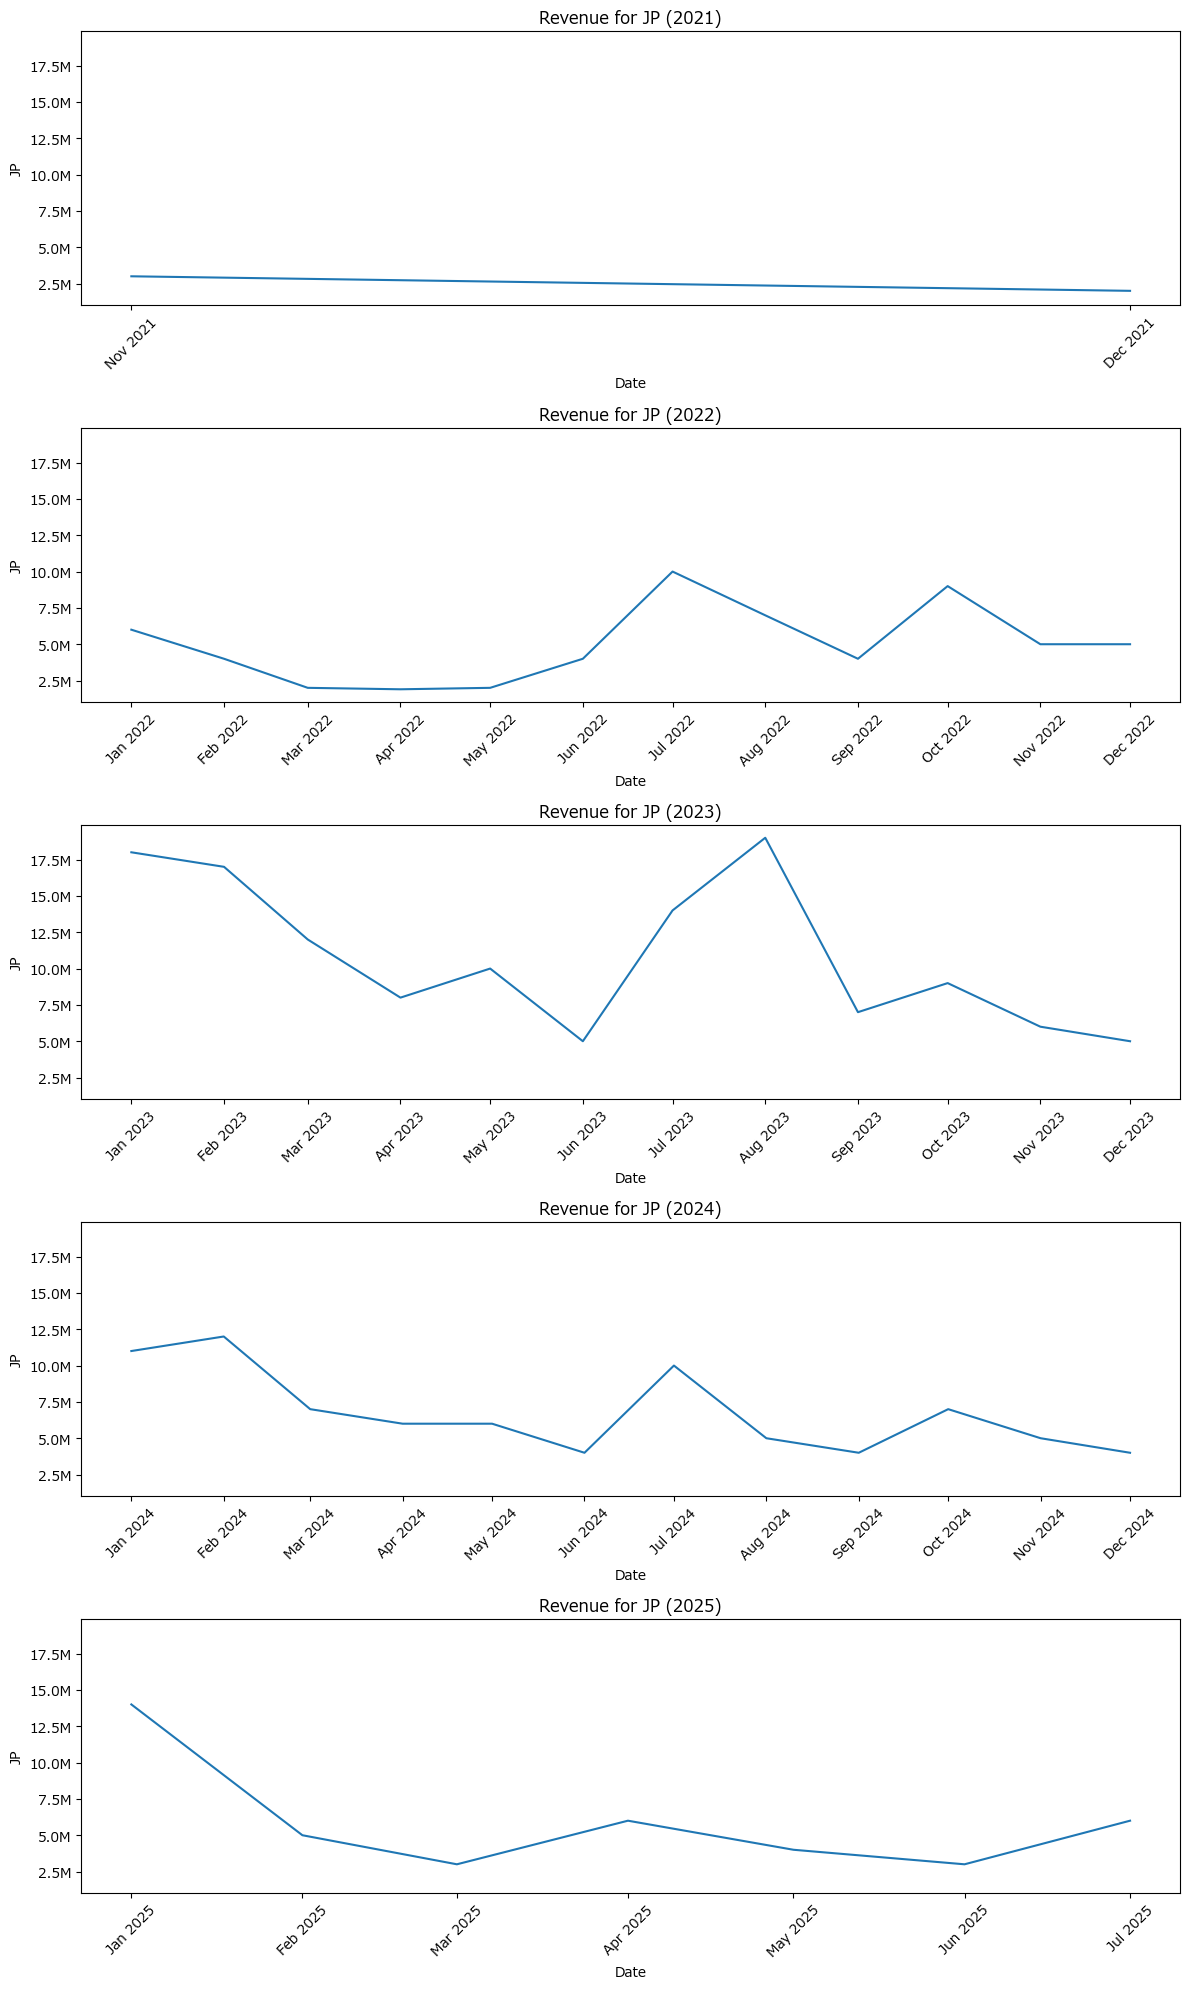

In [6]:
import utils.plotters as plotters
plotters.plot_revenue_monthly(revenue)

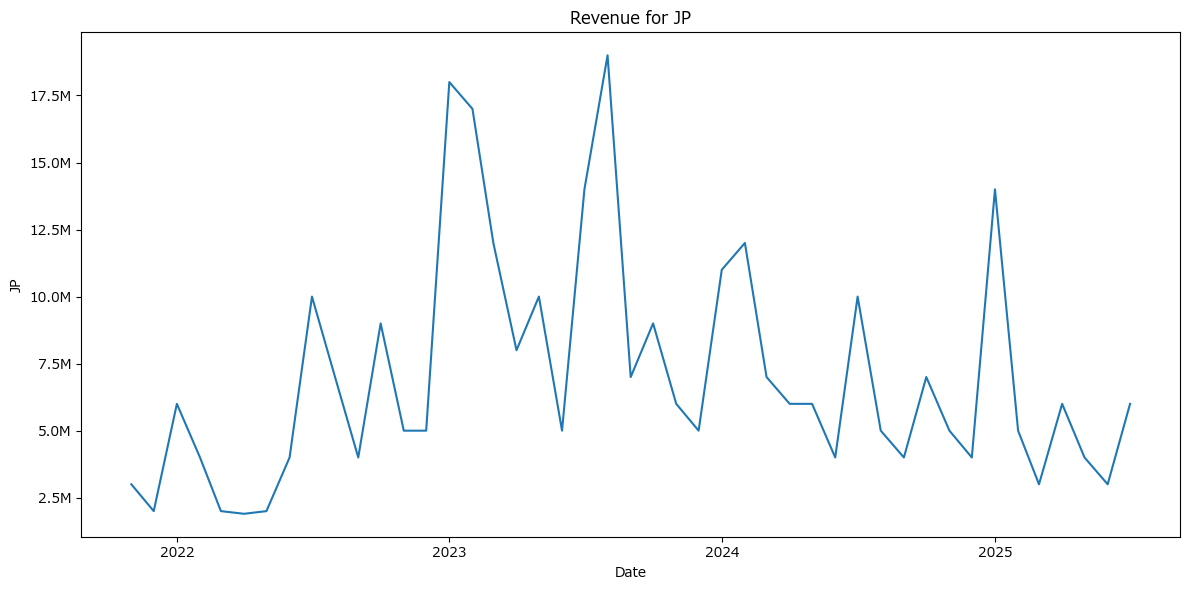

In [7]:
plotters.plot_revenue_yearly(revenue)

The game appears to have peak revenue at in the year of 2023, reaching up to 19M in sales. 

Furthermore, there appears to be seasonality in the data; for every year, there seems to be:
- a spike near the start of the year 
- a spike near the July-Aug period.

## Impact of Events

We take event to be some sort of feature that has at least a start date. Logically speaking, certain events ought to drive sales. For example, if there is a Festival Banner I would expect sales to spike for that month. Let's have a look at the impact of some events:

In [8]:
all_banners_jp['gachaType'].unique()

array(['PickupGacha', 'LimitedGacha', 'FesGacha'], dtype=object)

### Banners

In simple terms, when a banner is ongoing, you are able to participate in a 'lottery' (i.e. gacha) to stand a chance of getting the character you want. There are 3 types of gachas:

- Pickup: You have a higher chance of getting a particular character. However, that character can also be obtained (randomly) through any of the 3 types of gacha. Therefore, as long as you participate in any type of gacha there is some chance of obtaining that character. 

- Limited: You can only obtain the character during the banner period. If you miss it, you can't obtain it unless the banner appears again in the future.

- Festival: A banner designed to celebrate milestones (such as a 3rd anniversary, for example.) This banner works the same as a Limited, but typically features the most popular and powerful characters. 

In [9]:
all_banners_jp.head()

,id,gachaType,startedAt,endedAt,rateups,startAt,endAt
428,50004,PickupGacha,1612425600000,1613023199000,"[シロコ, ホシノ]",2021-02-04 08:00:00,2021-02-11 05:59:59
427,50005,PickupGacha,1613026800000,1614232860000,[マシロ],2021-02-11 07:00:00,2021-02-25 06:01:00
426,50011,PickupGacha,1614234600000,1615435200000,"[イズナ, シズコ]",2021-02-25 06:30:00,2021-03-11 04:00:00
425,50001,PickupGacha,1615091400000,1619668800000,[チェリノ],2021-03-07 04:30:00,2021-04-29 04:00:00
424,50013,PickupGacha,1615437000000,1616040000000,[ハルナ],2021-03-11 04:30:00,2021-03-18 04:00:00


In [10]:
banners_categorized = dataloader_utils.categorize_banners(all_banners_jp)

fes_banners_jp = banners_categorized['fes'] 
pickup_banners_jp = banners_categorized['pickup']
limited_banners_jp = banners_categorized['limited']

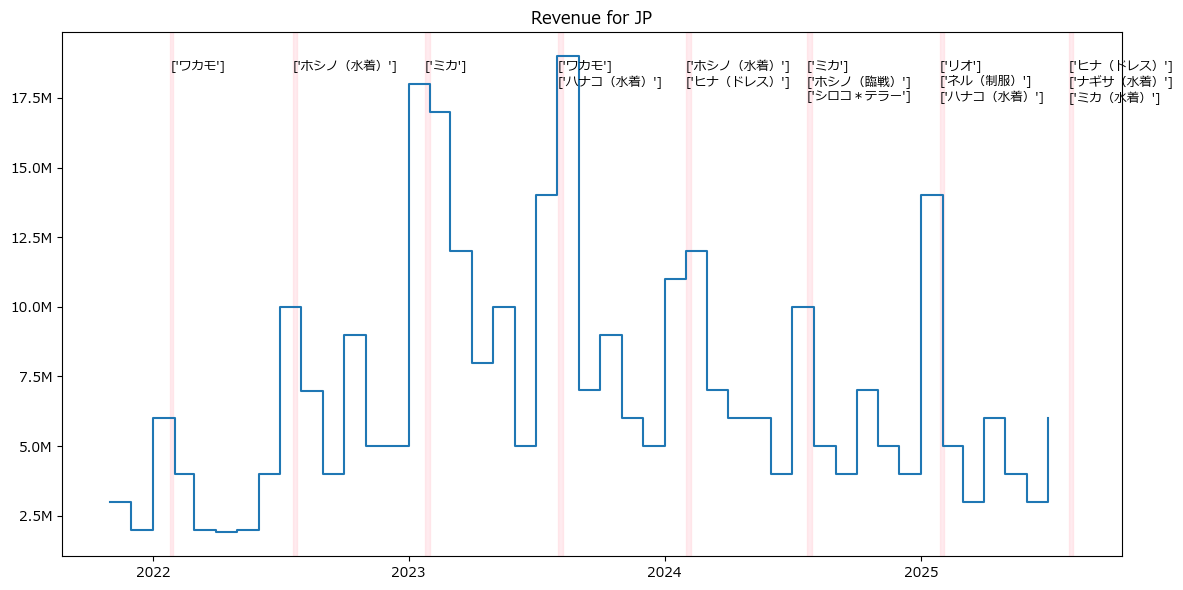

In [11]:
plotters.plot_revenue_yearly(df=revenue, region='JP', events_df=fes_banners_jp, step=True, custom_plotter=plotters.banner_region_plotter, label=True)

As expected, Fes banners drive the most sales. Local peaks correspond nicely to the release dates of the fest banners (region in pink), and this is probably the single best predictive feature. 
Players won't know the upcoming characters in advance, so they have to purchase resources when the character is released (if they have insufficient resources).

The most popular banners appear to be for:
- Mika (Jan 23)
- S. Hanako (Aug 23)

The above characters happen to be quite popular (and powerful in game too!)

For simplicity, we won't translate character names since names won't be used as a feature.

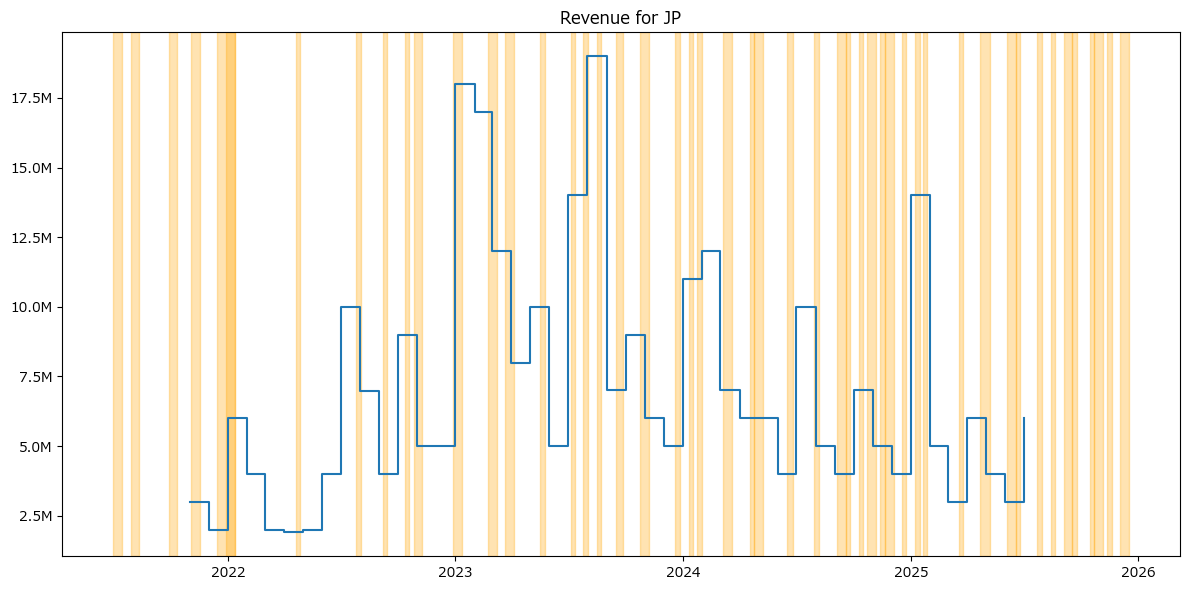

In [12]:
plotters.plot_revenue_yearly(df=revenue, region='JP', events_df=limited_banners_jp, step=True, custom_plotter=plotters.banner_region_plotter, label=False)

Troughs do not appear to have many limited banners, in general. So it might be the case that when there are multiple limited banners close to each other, revenue tends to be higher. Players might have insufficient resources to obtain these characters back to back, forcing them to make a purchase. 

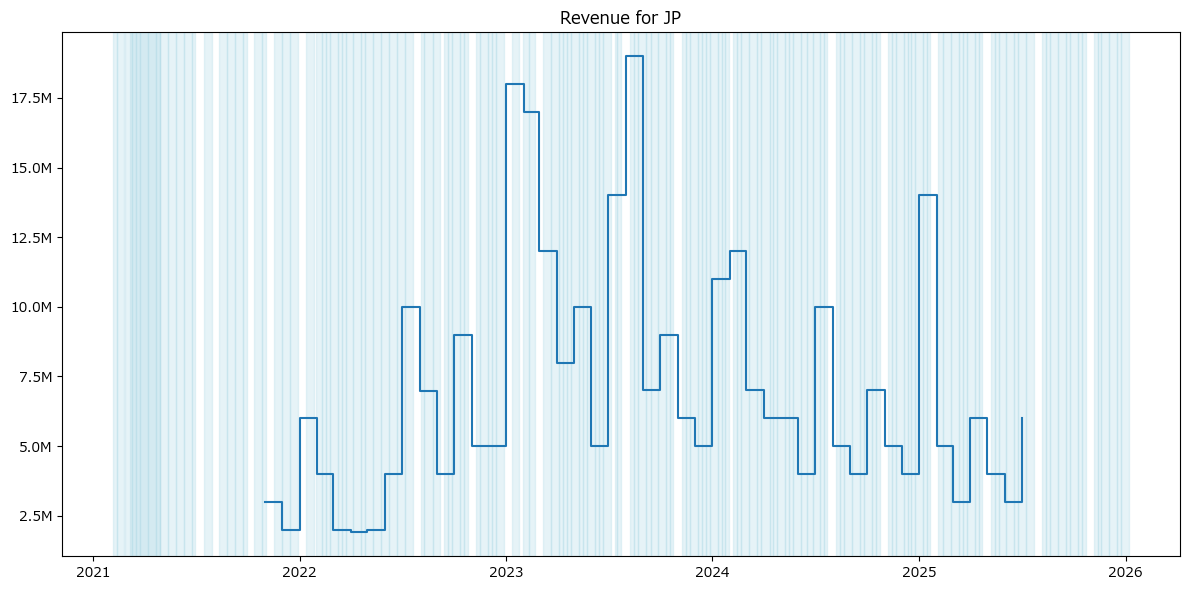

In [13]:
plotters.plot_revenue_yearly(df=revenue, region='JP', events_df=pickup_banners_jp, step=True, custom_plotter=plotters.banner_region_plotter, label=False)

There doesn't seem to much relation between pick-up banners and revenue.

### Story

In [14]:
story_jp

,Volume,Full Name,Chapter,Part,Release Date
0,1,The Foreclosure Task Force,1,NaN,2021-02-04 00:00:00
1,1,The Foreclosure Task Force,2,1.0,2021-03-11 00:00:00
2,1,The Foreclosure Task Force,2,2.0,2021-03-18 00:00:00
3,1,The Foreclosure Task Force,3,0.0,2024-02-07 00:00:00
4,1,The Foreclosure Task Force,3,1.0,2024-04-11 00:00:00
5,1,The Foreclosure Task Force,3,2.0,2024-05-06 00:00:00
6,1,The Foreclosure Task Force,3,3.0,2024-06-19 00:00:00
7,1,The Foreclosure Task Force,3,4.0,2024-07-17 00:00:00
8,1,The Foreclosure Task Force,3,5.0,2024-07-22 00:00:00
9,2,Clockwork Flower Pavane,1,NaN,2021-03-25 00:00:00


In [15]:
import seaborn as sns
import numpy as np
import pickle

colors = sns.color_palette("Set2", len(story_jp['Full Name'].unique()))
color_dict = dict(zip(story_jp['Full Name'].unique(), colors))
pickle.dump(color_dict, open('./data/fixtures/story_color_dict.pkl', 'wb'))

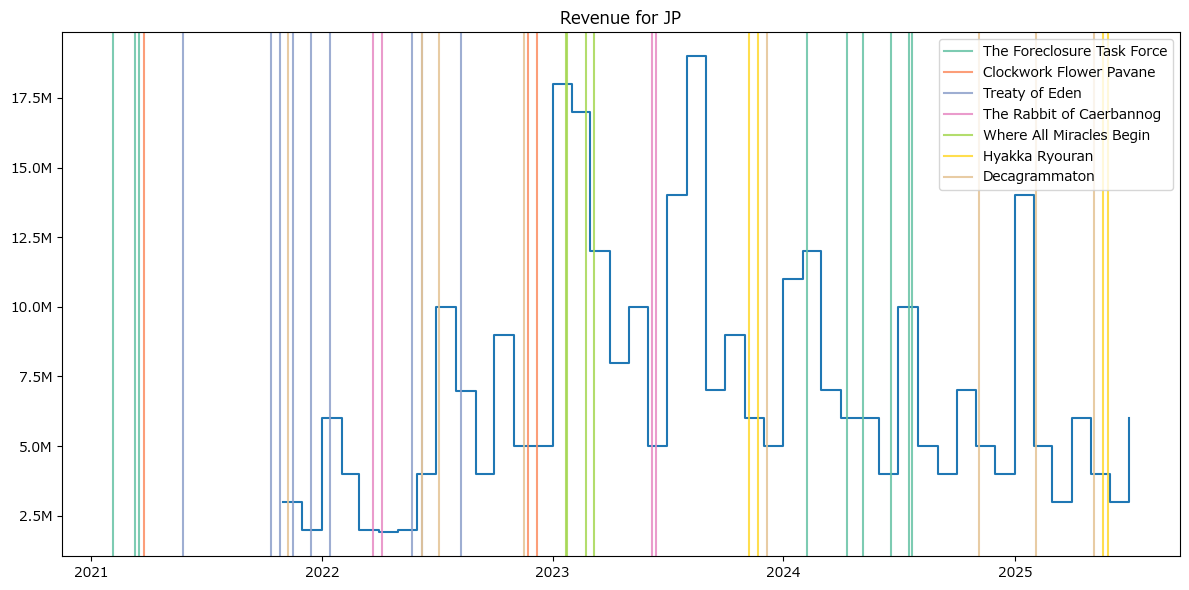

In [16]:
plotters.plot_revenue_yearly(revenue, events_df=story_jp, step=True, custom_plotter=plotters.story_plotter, label=False, legend=True)

Some stories we know are popular (e.g. Foreclosure Task Force, Where All Miracles Begin), while others may not be as popular. Popular stories may or may not be associated with higher revenue. A possible approach might be to create features:
- number of stories this month 
- is there a popular story this month 

Of course, it's hard to predict if a story will be popular in the future, so we can leave that as 0 unless we have strong reason to believe otherwise. 

### Event

In [17]:
event_jp.head()

,Name (EN),Name (JP),Start date,End date,Notes
0,Cherry Blossom Festival Commotion! ~Flowers in...,桜花爛漫お祭り騒ぎ！~空に徒花 地に忍び~,2021-02-25,2021-03-11,NaN
1,"Revolutionary Ivan Kupala: Moustache, Pudding ...",革命のイワン・クパーラ 髭とプリンとレッドウィンター,2021-04-29,2021-05-13,NaN
2,Summer Sky's Wishlist,夏空のウィッシュリスト,2021-06-30,2021-07-15,NaN
3,～Emergency Special Order of the Disciplinary c...,～風紀委員会行政官緊急特務命令～ ヒナ委員長のなつやすみっ！,2021-07-29,2021-08-12,NaN
4,Catch in Neverland,ネバーランドでつかまえて,2021-08-26,2021-09-09,NaN


Let's have a look at rerun events:

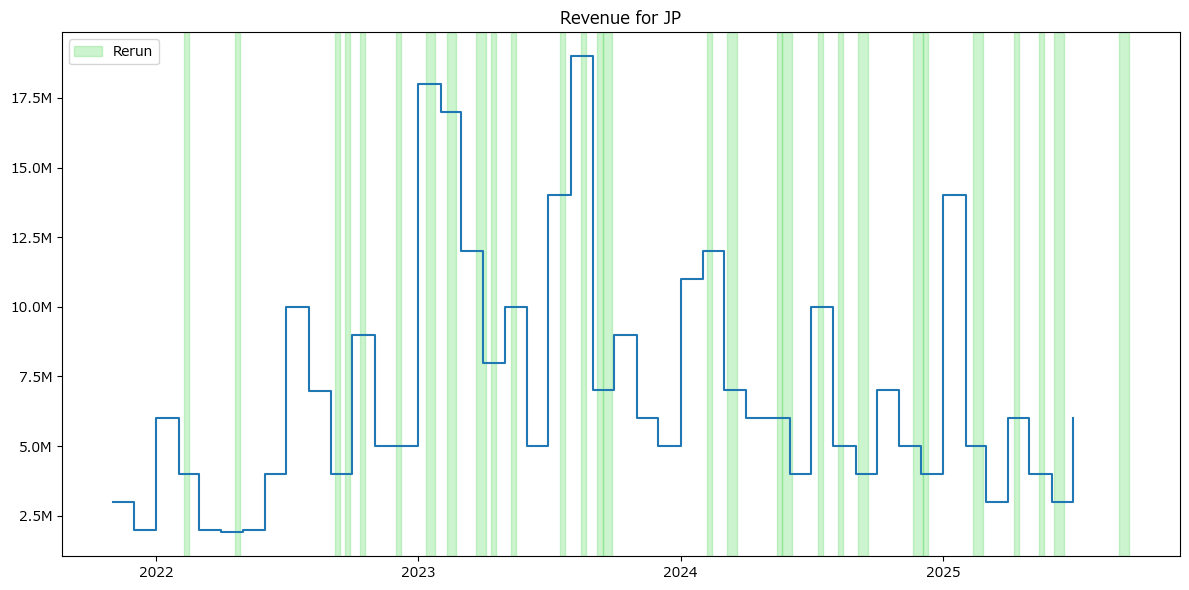

In [18]:
rerun_events = event_jp[event_jp['Notes'].apply(plotters.classify_event) == 'Rerun']
plotters.plot_revenue_yearly(revenue, events_df=rerun_events, step=True, custom_plotter=plotters.event_plotter, legend=True)

It seems like rerun events are often associated with 'dead weeks' where there is no new content. Therefore, I would expect revenue to be lower when rerun events occur.

Next, let's have a look at original events (events that occur for the first time).

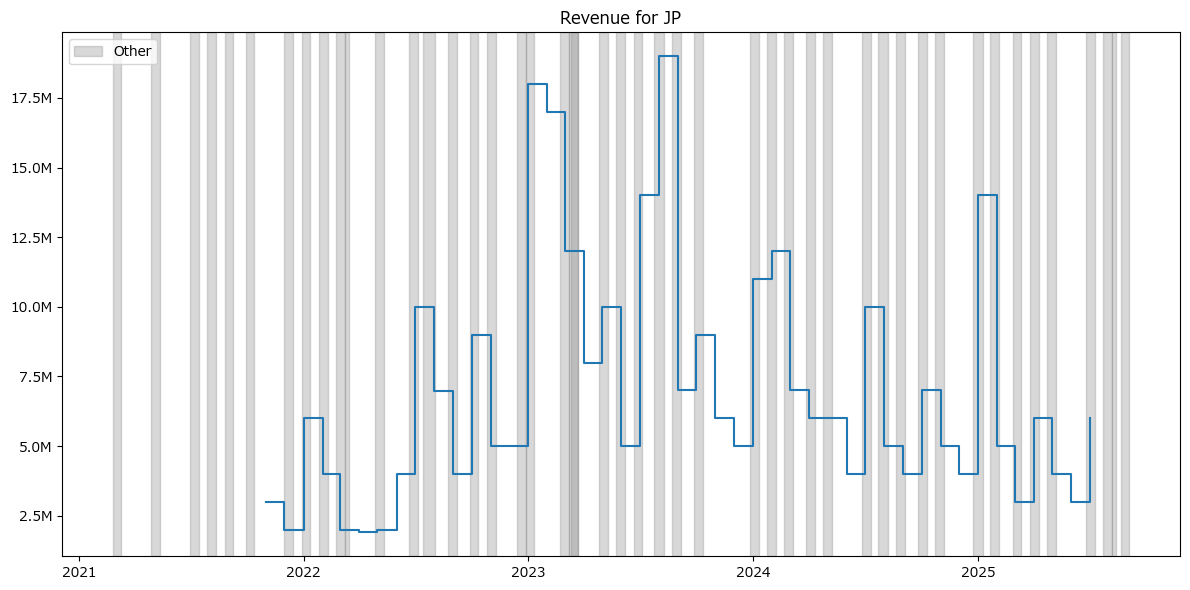

In [19]:
rerun_events = event_jp[event_jp['Notes'].apply(plotters.classify_event) == 'Other']
plotters.plot_revenue_yearly(revenue, events_df=rerun_events, step=True, custom_plotter=plotters.event_plotter, legend=True)

# Data Cleaning

## Revenue Data

We will not be working with global data from now on. Some reasons include: 

- Lack of data
- Accelerated Schedule
- Not the most recent updates and characters

In [20]:
# pickle.dump(revenue, open('./data/fixtures/integration_testing/test_cleaning/revenue.pkl', 'wb')) # for integration testing

In [21]:
import utils.cleaning_utils as cleaning_utils

revenue = cleaning_utils.drop_global_data_from_revenue(revenue)
revenue

,Date,JP
0,2021-11-01,3000000.0
1,2021-12-01,2000000.0
2,2022-01-01,6000000.0
3,2022-02-01,4000000.0
4,2022-03-01,2000000.0
5,2022-04-01,1900000.0
6,2022-05-01,2000000.0
7,2022-06-01,4000000.0
8,2022-07-01,10000000.0
9,2022-08-01,6989822.0


## Banner Data

We don't really need to know the character's name, just the gacha type and date. Hence, we will leave the banner data as is and ignore any possible translation issues.

In [22]:
all_banners_jp.head()

,id,gachaType,startedAt,endedAt,rateups,startAt,endAt
428,50004,PickupGacha,1612425600000,1613023199000,"[シロコ, ホシノ]",2021-02-04 08:00:00,2021-02-11 05:59:59
427,50005,PickupGacha,1613026800000,1614232860000,[マシロ],2021-02-11 07:00:00,2021-02-25 06:01:00
426,50011,PickupGacha,1614234600000,1615435200000,"[イズナ, シズコ]",2021-02-25 06:30:00,2021-03-11 04:00:00
425,50001,PickupGacha,1615091400000,1619668800000,[チェリノ],2021-03-07 04:30:00,2021-04-29 04:00:00
424,50013,PickupGacha,1615437000000,1616040000000,[ハルナ],2021-03-11 04:30:00,2021-03-18 04:00:00


## Story Data

Some chapters don't come with a part. For now, let's impute the missing values with 'None', since the missing values are actually story chapters with no part.

In [23]:
# pickle.dump(story_jp, open('./data/fixtures/integration_testing/test_cleaning/story_jp.pkl', 'wb')) # for integration testing

In [24]:
import utils.cleaning_utils as cleaning_utils

story_jp = cleaning_utils.impute_story_part(story_jp)
story_jp.head()

,Volume,Full Name,Chapter,Part,Release Date
0,1,The Foreclosure Task Force,1,None,2021-02-04 00:00:00
1,1,The Foreclosure Task Force,2,1.0,2021-03-11 00:00:00
2,1,The Foreclosure Task Force,2,2.0,2021-03-18 00:00:00
3,1,The Foreclosure Task Force,3,0.0,2024-02-07 00:00:00
4,1,The Foreclosure Task Force,3,1.0,2024-04-11 00:00:00


## Event Data

It appears that some of the events are inconsistently named. Looking at the Name (EN) column, some events have (Rerun) affixed to them while others don't. For consistency, we will remove the '(Rerun) ' prefix and rely on the 'Notes' column to tell us whether an event is a rerun or not. For simplicity, we will leave Name (JP) alone.

In [25]:
# pickle.dump(event_jp, open('./data/fixtures/integration_testing/test_cleaning/event_jp.pkl', 'wb')) # for integration testing

In [26]:
event_jp.iloc[11]

Name (EN)     (Rerun) Cherry Blossom Festival Commotion! ~Fl...
Name (JP)                             【復刻】桜花爛漫お祭り騒ぎ！～空に徒花 地に忍び～
Start date                                  2022-02-09 00:00:00
End date                                    2022-02-16 00:00:00
Notes                                                     Rerun
Name: 11, dtype: object

In [27]:
event_jp = cleaning_utils.remove_rerun_prefix(event_jp)
event_jp.iloc[11]

Name (EN)     Cherry Blossom Festival Commotion! ~Flowers in...
Name (JP)                             【復刻】桜花爛漫お祭り騒ぎ！～空に徒花 地に忍び～
Start date                                  2022-02-09 00:00:00
End date                                    2022-02-16 00:00:00
Notes                                                     Rerun
Name: 11, dtype: object

Furthermore, it looks like some events weren't marked properly as 'rerun'. When events are rerun, it means an in-game event that occured before occurs again. This might not be the most exciting event for players. Let's mark any event that has appeared once as 'rerun'.

In [28]:
event_jp.iloc[60]

Name (EN)               Say-Bing!
Name (JP)               Say-Bing!
Start date    2024-06-26 00:00:00
End date      2024-07-10 00:00:00
Notes                         NaN
Name: 60, dtype: object

In [29]:
event_jp.iloc[81] # same event appears twice but not marked as rerun

Name (EN)               Say-Bing!
Name (JP)               Say-Bing!
Start date    2025-08-06 00:00:00
End date      2025-08-13 00:00:00
Notes                         NaN
Name: 81, dtype: object

Using the `duplicated` method, we can conveniently replace everything else with 'Original' too.

In [30]:
event_jp = cleaning_utils.mark_duplicates_as_rerun(event_jp)
event_jp.head()

,Name (EN),Name (JP),Start date,End date,Notes
0,Cherry Blossom Festival Commotion! ~Flowers in...,桜花爛漫お祭り騒ぎ！~空に徒花 地に忍び~,2021-02-25,2021-03-11,Original
1,"Revolutionary Ivan Kupala: Moustache, Pudding ...",革命のイワン・クパーラ 髭とプリンとレッドウィンター,2021-04-29,2021-05-13,Original
2,Summer Sky's Wishlist,夏空のウィッシュリスト,2021-06-30,2021-07-15,Original
3,～Emergency Special Order of the Disciplinary c...,～風紀委員会行政官緊急特務命令～ ヒナ委員長のなつやすみっ！,2021-07-29,2021-08-12,Original
4,Catch in Neverland,ネバーランドでつかまえて,2021-08-26,2021-09-09,Original


Lastly, let's just group all the 'operations' events together:

In [31]:
event_jp = cleaning_utils.group_all_operation_events_together(event_jp)
event_jp.head()

,Name (EN),Name (JP),Start date,End date,Notes
0,Cherry Blossom Festival Commotion! ~Flowers in...,桜花爛漫お祭り騒ぎ！~空に徒花 地に忍び~,2021-02-25,2021-03-11,Original
1,"Revolutionary Ivan Kupala: Moustache, Pudding ...",革命のイワン・クパーラ 髭とプリンとレッドウィンター,2021-04-29,2021-05-13,Original
2,Summer Sky's Wishlist,夏空のウィッシュリスト,2021-06-30,2021-07-15,Original
3,～Emergency Special Order of the Disciplinary c...,～風紀委員会行政官緊急特務命令～ ヒナ委員長のなつやすみっ！,2021-07-29,2021-08-12,Original
4,Catch in Neverland,ネバーランドでつかまえて,2021-08-26,2021-09-09,Original


# Feature Engineering

Since we are doing a forecasting event, we want each row of data to be one month of data. Of course, some data (such as banner release dates) don't exactly start at the start of the month and end at the end of the month, so we need to make some adjustments.

## Banner Data

We aim to group the banner data by month.

In this approach, an banner that occurs from 27 March to 1st April will be counted in both March and April.

In [32]:
revenue.head()

,Date,JP
0,2021-11-01,3000000.0
1,2021-12-01,2000000.0
2,2022-01-01,6000000.0
3,2022-02-01,4000000.0
4,2022-03-01,2000000.0


In [33]:
from utils import df_utils

def group_into_monthly_count(banners_categorized_dict, revenue):

    revenue = revenue.copy()

    monthly_count_pickup_jp = df_utils.group_into_monthly_count(banners_categorized_dict['pickup'], revenue)
    monthly_count_pickup_jp.rename(columns={'Banner Count': 'Pickup Banner Count'}, inplace=True)

    monthly_count_limited_jp = df_utils.group_into_monthly_count(banners_categorized_dict['limited'], revenue)
    monthly_count_limited_jp.rename(columns={'Banner Count': 'Limited Banner Count'}, inplace=True)

    monthly_count_fes_jp = df_utils.group_into_monthly_count(banners_categorized_dict['fes'], revenue)
    monthly_count_fes_jp.rename(columns={'Banner Count': 'Fes Banner Count'}, inplace=True)

    revenue = revenue.merge(monthly_count_pickup_jp, on='Date').merge(monthly_count_limited_jp, on='Date').merge(monthly_count_fes_jp, on='Date')
    return revenue

revenue = group_into_monthly_count(banners_categorized, revenue)
revenue.head()

,Date,JP,Pickup Banner Count,Limited Banner Count,Fes Banner Count
0,2021-11-01,3000000.0,4,1,0
1,2021-12-01,2000000.0,3,2,0
2,2022-01-01,6000000.0,3,2,1
3,2022-02-01,4000000.0,8,0,0
4,2022-03-01,2000000.0,8,0,0


## Story Data

We will adopt a similar 'count' approach as above. However, there is an issue with creating ordinal features (for example, with one-hot encoding). This is because our model doesn't really know what to do with unseen categories! 

Furthermore, from the above EDA there doesn't seem to be a clear relationship between story and revenue. 

To keep things simple, we will not include story data for now.

In [34]:
story_jp.head()

,Volume,Full Name,Chapter,Part,Release Date
0,1,The Foreclosure Task Force,1,None,2021-02-04 00:00:00
1,1,The Foreclosure Task Force,2,1.0,2021-03-11 00:00:00
2,1,The Foreclosure Task Force,2,2.0,2021-03-18 00:00:00
3,1,The Foreclosure Task Force,3,0.0,2024-02-07 00:00:00
4,1,The Foreclosure Task Force,3,1.0,2024-04-11 00:00:00


## Event Data

For this category, we will just sum up the amount ot each type of event by month and use that as a feature.

In [35]:
event_jp.head()

,Name (EN),Name (JP),Start date,End date,Notes
0,Cherry Blossom Festival Commotion! ~Flowers in...,桜花爛漫お祭り騒ぎ！~空に徒花 地に忍び~,2021-02-25,2021-03-11,Original
1,"Revolutionary Ivan Kupala: Moustache, Pudding ...",革命のイワン・クパーラ 髭とプリンとレッドウィンター,2021-04-29,2021-05-13,Original
2,Summer Sky's Wishlist,夏空のウィッシュリスト,2021-06-30,2021-07-15,Original
3,～Emergency Special Order of the Disciplinary c...,～風紀委員会行政官緊急特務命令～ ヒナ委員長のなつやすみっ！,2021-07-29,2021-08-12,Original
4,Catch in Neverland,ネバーランドでつかまえて,2021-08-26,2021-09-09,Original


In [36]:
def group_event_types_into_monthly_count(event_jp, revenue):
    revenue = revenue.copy()
    for event_type in event_jp['Notes'].unique():
        event_type_df = event_jp[event_jp['Notes'] == event_type]
        monthly_count_event_type = df_utils.group_event_into_monthly_count(event_type_df, revenue)
        monthly_count_event_type.rename(columns={'Event Count': f'{event_type} Count'}, inplace=True)
        revenue = revenue.merge(monthly_count_event_type, on='Date')
    return revenue

revenue = group_event_types_into_monthly_count(event_jp, revenue)
revenue.head()

,Date,JP,Pickup Banner Count,Limited Banner Count,Fes Banner Count,Original Count,Collaboration Event Count,Operation Count,Rerun Count
0,2021-11-01,3000000.0,4,1,0,1,1,1,0
1,2021-12-01,2000000.0,3,2,0,2,0,0,0
2,2022-01-01,6000000.0,3,2,1,2,0,0,0
3,2022-02-01,4000000.0,8,0,0,2,0,0,1
4,2022-03-01,2000000.0,8,0,0,1,0,0,1


## Fourier Pairs 

We can use pairs of sin and cos curves as features to learn about seasonality. To put things very simply, by combining these curves together, we can create more detailed curves. 

A periodogram tells us the dominant frequencies of a signal. We will use this to determine which fourier pairs to include:

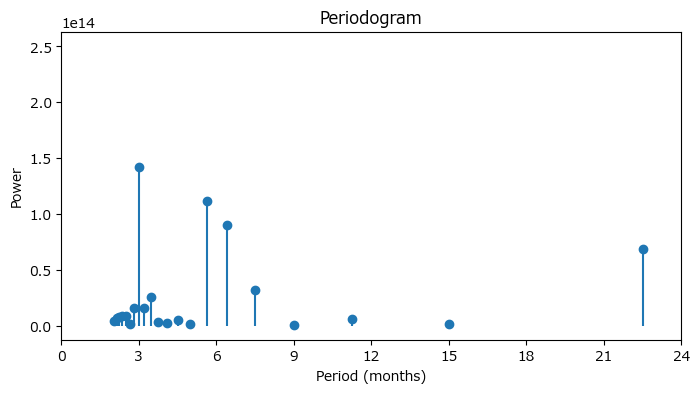

In [37]:
from scipy.signal import periodogram

# Compute periodogram
freqs, power = periodogram(revenue['JP'])

# Plot
periods = 1 / freqs[1:]  # skip 0 frequency to avoid division by zero

plt.figure(figsize=(8,4))
plt.stem(periods, power[1:], basefmt=" ")
plt.xlabel("Period (months)")
plt.ylabel("Power")
plt.title("Periodogram")
plt.xticks(np.arange(0, 24+1, 3))
plt.xlim(0, 24)  
plt.show()

As we can see, the periodogram has peaks at 3 and 6 months. What that tells us is that there are probably 3 and 6 month cycles. The 6 month cycle is actually expected (due to the fact that Fes banners and many rewards tend to appear once every 6 months). 

Therefore, we will use 4th order calendar fourier to capture the shortest important cycle:
- order 1: 12 months
- order 2: 6 months
- order 3: 4 months 
- order 4: 3 months (stop here)

In [38]:
# pickle.dump(banners_categorized, open('./data/fixtures/integration_testing/test_feature_engineering/banners_categorized.pkl', 'wb'))
# pickle.dump(revenue, open('./data/fixtures/integration_testing/test_feature_engineering/revenue.pkl', 'wb'))

In [39]:
import utils.df_utils as df_utils

revenue = df_utils.create_fourier_features(revenue)
revenue.head()

,Date,JP,Pickup Banner Count,Limited Banner Count,Fes Banner Count,Original Count,Collaboration Event Count,Operation Count,Rerun Count,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)","sin(4,freq=YE-DEC)","cos(4,freq=YE-DEC)"
0,2021-11-01,3000000.0,4,1,0,1,1,1,0,-0.867456,0.497513,-0.863142,-0.504961,0.008607,-0.999963,0.871706,-0.490029
1,2021-12-01,2000000.0,3,2,0,2,0,0,0,-0.508671,0.860961,-0.875892,0.482508,-0.999546,-0.030120,-0.845249,-0.534373
2,2022-01-01,6000000.0,3,2,1,2,0,0,0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
3,2022-02-01,4000000.0,8,0,0,2,0,0,1,0.508671,0.860961,0.875892,0.482508,0.999546,-0.030120,0.845249,-0.534373
4,2022-03-01,2000000.0,8,0,0,1,0,0,1,0.849817,0.527078,0.895839,-0.444378,0.094537,-0.995521,-0.796183,-0.605056


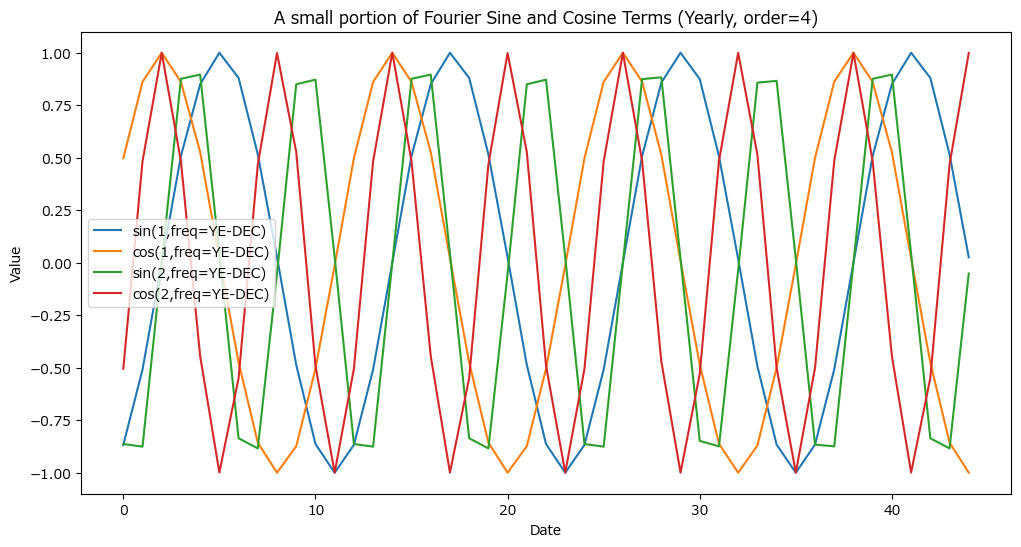

In [40]:
# Select only the Fourier columns
fourier_cols = [col for col in revenue.columns if 'sin' in col or 'cos' in col]

plt.figure(figsize=(12,6))

for col in fourier_cols[0:4]: # first few just for visualiation purposes
    plt.plot(revenue.index, revenue[col], label=col)

plt.title("A small portion of Fourier Sine and Cosine Terms (Yearly, order=4)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()


As expected, the fourier curves were generated correctly.

## Lags

Values could be dependent on previous values. We can use lag plots to identify these associations:

In [41]:
revenue.head()

,Date,JP,Pickup Banner Count,Limited Banner Count,Fes Banner Count,Original Count,Collaboration Event Count,Operation Count,Rerun Count,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)","sin(4,freq=YE-DEC)","cos(4,freq=YE-DEC)"
0,2021-11-01,3000000.0,4,1,0,1,1,1,0,-0.867456,0.497513,-0.863142,-0.504961,0.008607,-0.999963,0.871706,-0.490029
1,2021-12-01,2000000.0,3,2,0,2,0,0,0,-0.508671,0.860961,-0.875892,0.482508,-0.999546,-0.030120,-0.845249,-0.534373
2,2022-01-01,6000000.0,3,2,1,2,0,0,0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
3,2022-02-01,4000000.0,8,0,0,2,0,0,1,0.508671,0.860961,0.875892,0.482508,0.999546,-0.030120,0.845249,-0.534373
4,2022-03-01,2000000.0,8,0,0,1,0,0,1,0.849817,0.527078,0.895839,-0.444378,0.094537,-0.995521,-0.796183,-0.605056


In [42]:
import pandas as pd

lags = pd.DataFrame(revenue['JP'])
for lag in range(1, 9):  # 1 through 8
    lags[f'JP_lag{lag}'] = lags['JP'].shift(lag)
lags.head()

,JP,JP_lag1,JP_lag2,JP_lag3,JP_lag4,JP_lag5,JP_lag6,JP_lag7,JP_lag8
0,3000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000000.0,3000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6000000.0,2000000.0,3000000.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4000000.0,6000000.0,2000000.0,3000000.0,NaN,NaN,NaN,NaN,NaN
4,2000000.0,4000000.0,6000000.0,2000000.0,3000000.0,NaN,NaN,NaN,NaN


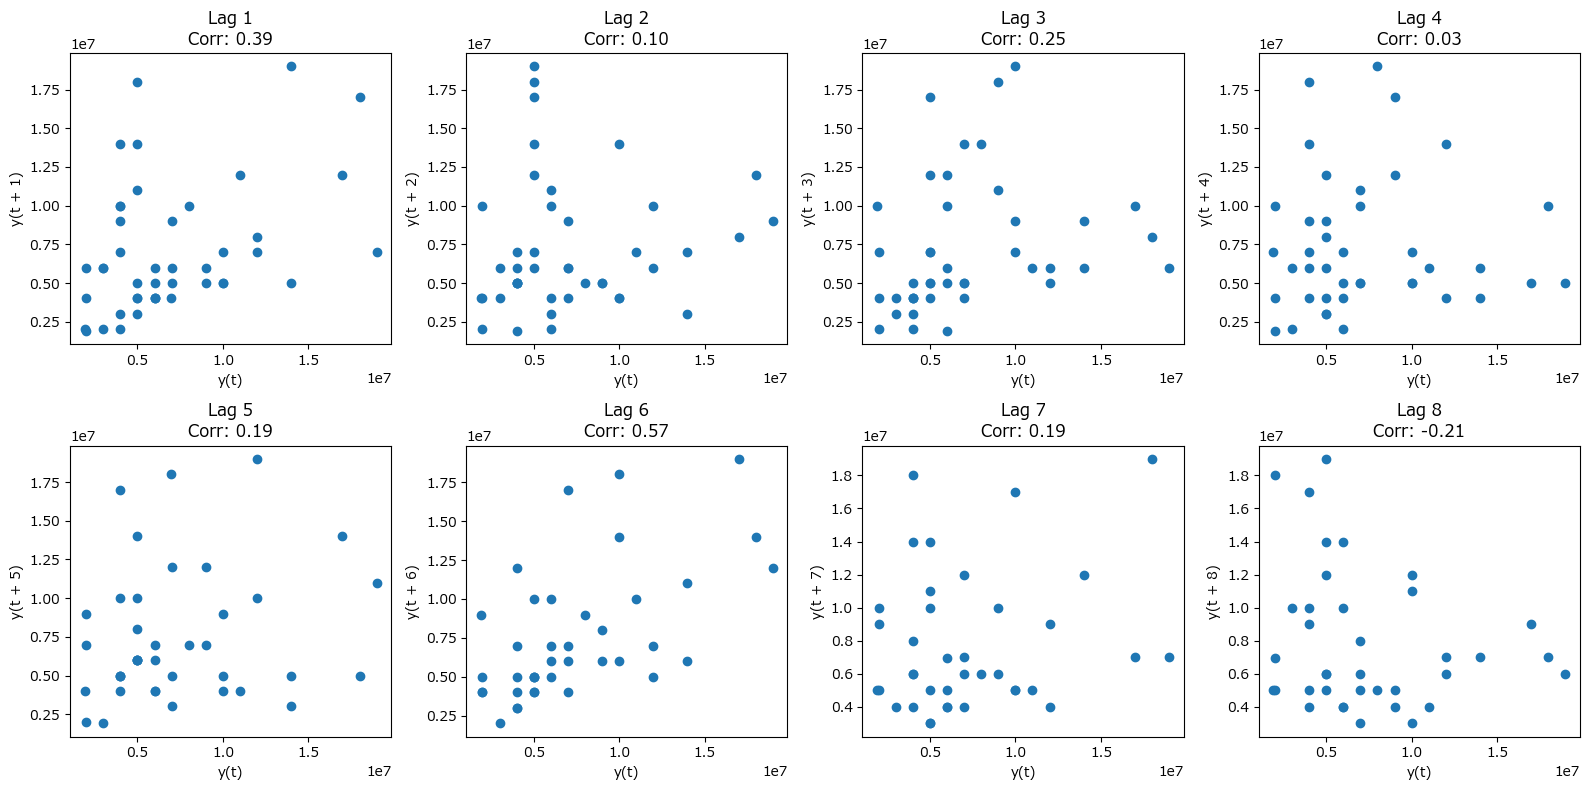

In [43]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(2, 4, figsize=(16,8))  # 2 rows x 4 columns

for i, ax in enumerate(axes.flatten(), start=1):
    lag_plot(revenue['JP'], lag=i, ax=ax)

    corr = revenue['JP'].autocorr(lag=i)
    ax.set_title(f"Lag {i}\nCorr: {corr:.2f}")

plt.tight_layout()
plt.show()

Let's use lag1, since lag6 would cause us to lose too much data. We will do so after extracting the trend.

# Modelling

## Modelling the overall trend

We will use linear regression to fit the trend, and XGBoost to fit the residuals. To test the validity, we will try to predict the last 6 months of data (and use anything before that for training.)

In [44]:
revenue.head()

,Date,JP,Pickup Banner Count,Limited Banner Count,Fes Banner Count,Original Count,Collaboration Event Count,Operation Count,Rerun Count,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)","sin(4,freq=YE-DEC)","cos(4,freq=YE-DEC)"
0,2021-11-01,3000000.0,4,1,0,1,1,1,0,-0.867456,0.497513,-0.863142,-0.504961,0.008607,-0.999963,0.871706,-0.490029
1,2021-12-01,2000000.0,3,2,0,2,0,0,0,-0.508671,0.860961,-0.875892,0.482508,-0.999546,-0.030120,-0.845249,-0.534373
2,2022-01-01,6000000.0,3,2,1,2,0,0,0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
3,2022-02-01,4000000.0,8,0,0,2,0,0,1,0.508671,0.860961,0.875892,0.482508,0.999546,-0.030120,0.845249,-0.534373
4,2022-03-01,2000000.0,8,0,0,1,0,0,1,0.849817,0.527078,0.895839,-0.444378,0.094537,-0.995521,-0.796183,-0.605056


In [45]:
# pickle.dump(revenue, open('./data/fixtures/integration_testing/test_model_training/revenue.pkl', 'wb'))

In [46]:
import utils.model_utils as model_utils

X_train, y_train, X_test, y_test = model_utils.prepare_train_test_split(revenue)

First, let's try to model the trend. Since the actual revenue data is very spiky, we will attempt to use a rolling average to smooth it out.

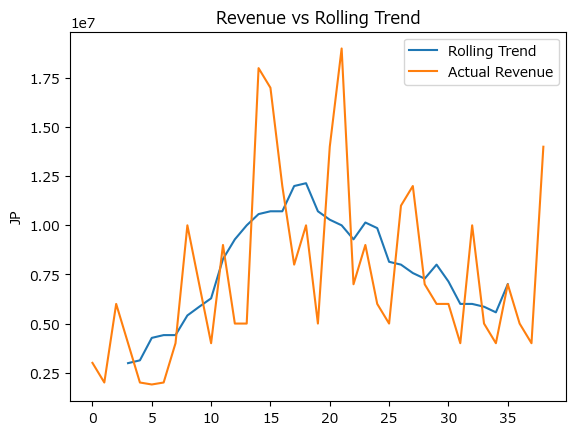

In [47]:
window_size = 7  # 7-month rolling window
trend = y_train.rolling(window=window_size, center=True).mean()
trend

sns.lineplot(trend, label='Rolling Trend')
sns.lineplot(y_train, label='Actual Revenue')
plt.title('Revenue vs Rolling Trend')
plt.show()

Trying to fit it to a single polynomial is quite difficult (because of the sharper rise at the start, then gradual fall). Therefore, we will use a spline (which is a combination of polynomials). Through a bit of trial and error, we have 7 knots and degree 1 polynomials.

c:\Anaconda\envs\ba-forecasting\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but SplineTransformer was fitted without feature names
  warnings.warn(


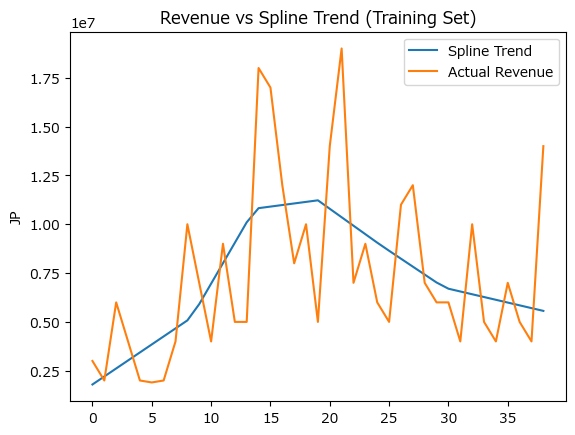

In [48]:
trend_model = model_utils.fit_spline_trend_model(y_train, window_size)

Let's see if the trend prediction is accurate by including the last 6 months (of test data):

c:\Anaconda\envs\ba-forecasting\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but SplineTransformer was fitted without feature names
  warnings.warn(


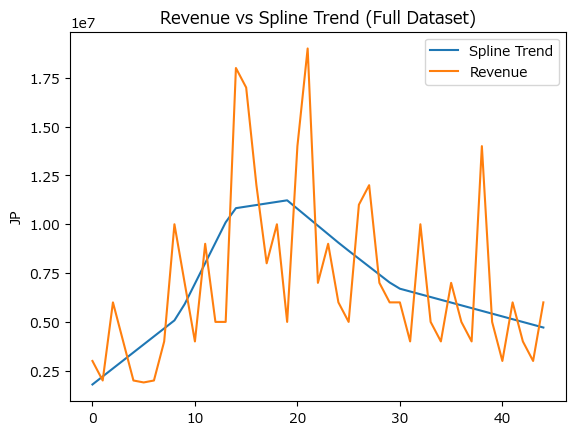

In [49]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


dp = DeterministicProcess(index=y_train.index, order=1)

full_sample = pd.concat([dp.in_sample(), dp.out_of_sample(steps=len(y_test))])
sns.lineplot(trend_model.predict(full_sample), label='Spline Trend')
sns.lineplot(revenue['JP'], label='Revenue')
plt.title('Revenue vs Spline Trend (Full Dataset)')
plt.show()

The trend spline seems to be accurate!

c:\Anaconda\envs\ba-forecasting\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but SplineTransformer was fitted without feature names
  warnings.warn(


<Axes: ylabel='JP'>

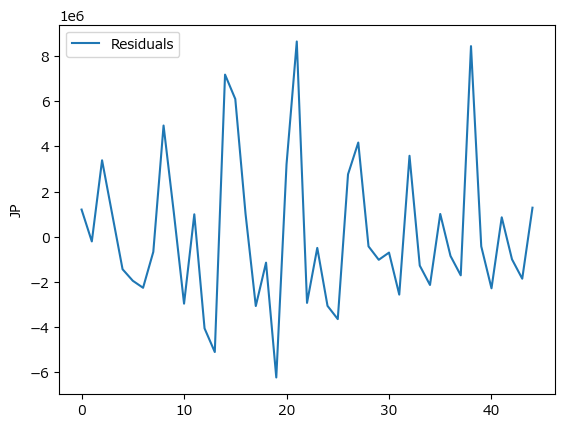

In [50]:
sns.lineplot(revenue['JP'] - trend_model.predict(full_sample), label='Residuals')

## Modelling the residuals (seasons, cycles etc.)

Let's obtain the residuals by subtracting the trend from the actual revenue:

c:\Anaconda\envs\ba-forecasting\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but SplineTransformer was fitted without feature names
  warnings.warn(
c:\Anaconda\envs\ba-forecasting\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but SplineTransformer was fitted without feature names
  warnings.warn(


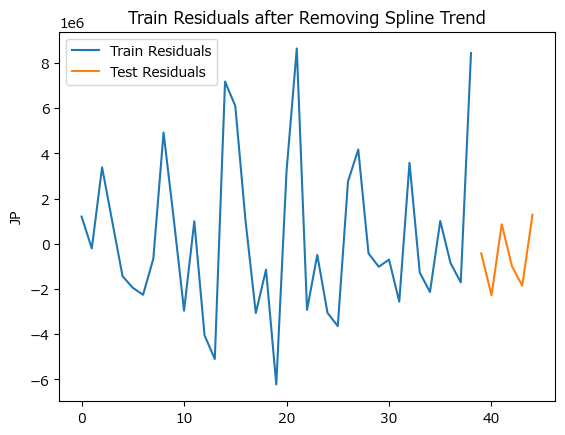

In [51]:
train_residuals = y_train - trend_model.predict(dp.in_sample())
test_residuals = y_test - trend_model.predict(dp.out_of_sample(steps=6))
sns.lineplot(train_residuals, label='Train Residuals')
sns.lineplot(test_residuals, label='Test Residuals')
plt.title('Train Residuals after Removing Spline Trend')
plt.show()

As we can see, there appears to be groups of a large spike followed by a small spike. This could be indicative of cycles. Furthermore, these groups appear to be somewhat evenly spread out, perhaps indicating seasonality.

We will now attempt to model these residuals using XGBoost, and the features we have collated earlier. Let's drop the date from `revenue_train` (since that should be accounted for by the spline). Also, we will drop the actual revenue (since that would obviously be leakage!).

We will also:
* Create lags as explained earlier
* Create some rolling statistics (rolling mean, SD)
* Drop rows with NA (NA is caused by creating lags and rolling statistics.)

In [52]:
revenue.head()

,Date,JP,Pickup Banner Count,Limited Banner Count,Fes Banner Count,Original Count,Collaboration Event Count,Operation Count,Rerun Count,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)","sin(4,freq=YE-DEC)","cos(4,freq=YE-DEC)"
0,2021-11-01,3000000.0,4,1,0,1,1,1,0,-0.867456,0.497513,-0.863142,-0.504961,0.008607,-0.999963,0.871706,-0.490029
1,2021-12-01,2000000.0,3,2,0,2,0,0,0,-0.508671,0.860961,-0.875892,0.482508,-0.999546,-0.030120,-0.845249,-0.534373
2,2022-01-01,6000000.0,3,2,1,2,0,0,0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
3,2022-02-01,4000000.0,8,0,0,2,0,0,1,0.508671,0.860961,0.875892,0.482508,0.999546,-0.030120,0.845249,-0.534373
4,2022-03-01,2000000.0,8,0,0,1,0,0,1,0.849817,0.527078,0.895839,-0.444378,0.094537,-0.995521,-0.796183,-0.605056


In [53]:
import utils.model_utils as model_utils

revenue_2 = model_utils.create_XGB_features(revenue)
revenue_2.head()

,JP,Pickup Banner Count,Fes Banner Count,Original Count,"sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","cos(4,freq=YE-DEC)",lag6,rolling_std_4
6,2000000.0,6,0,1,-0.835925,-0.548843,-0.397543,3000000.0,1.941434e+06
7,4000000.0,6,0,1,-0.884068,0.467359,-0.563151,2000000.0,1.017759e+06
8,10000000.0,4,1,2,-0.051620,0.998667,0.994671,6000000.0,1.017759e+06
9,6989822.0,6,0,2,0.849817,0.527078,-0.444378,4000000.0,3.808215e+06
10,4000000.0,9,0,2,0.871706,-0.490029,-0.519744,2000000.0,3.498792e+06


Let's not forget to drop the revenue:

In [54]:
X_train2 = revenue_2.iloc[:-6].drop(columns=['JP'])
X_test2 = revenue_2.iloc[-6:].drop(columns=['JP'])

y_train2 = train_residuals.iloc[X_train2.index]
y_test2 = test_residuals

We will then fit the XGB Regressor!

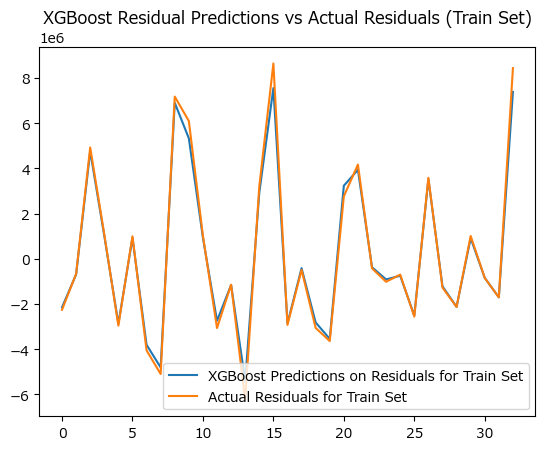

In [55]:
xgb_model = model_utils.fit_XGB_residual_model(X_train2, y_train2)

sns.lineplot(xgb_model.predict(X_train2), label='XGBoost Predictions on Residuals for Train Set')
sns.lineplot(y_train2.to_numpy(), label='Actual Residuals for Train Set')
plt.title('XGBoost Residual Predictions vs Actual Residuals (Train Set)')
plt.show()

And calculate the MAE:

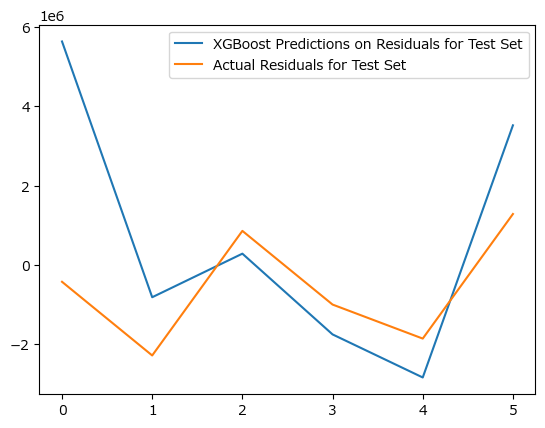

2012383.876459732


In [56]:
sns.lineplot(xgb_model.predict(X_test2), label = 'XGBoost Predictions on Residuals for Test Set')
sns.lineplot(test_residuals.to_numpy(), label='Actual Residuals for Test Set')
plt.show()

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test2.to_numpy(), xgb_model.predict(X_test2))
print(mae)

Explaining the importance of features:

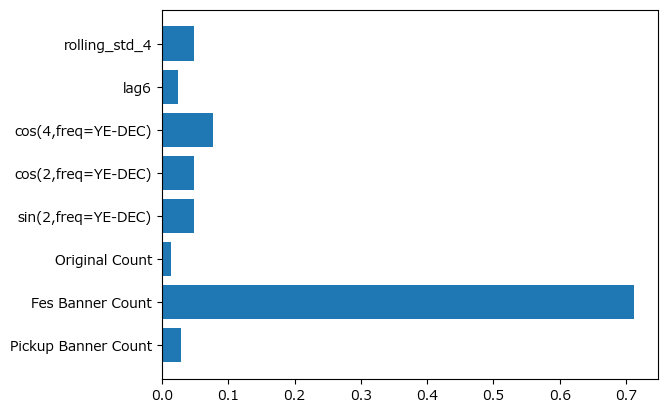

['Pickup Banner Count' 'Fes Banner Count' 'Original Count'
 'sin(2,freq=YE-DEC)' 'cos(2,freq=YE-DEC)' 'cos(4,freq=YE-DEC)' 'lag6'
 'rolling_std_4']


In [57]:
plt.barh(xgb_model.feature_names_in_, xgb_model.feature_importances_)
plt.show()
print(xgb_model.feature_names_in_)

In predicting the residuals, the fes banner count appears to be the highest by far, with fourier features and rolling features playing a minor role in prediction. The best 8 features were chosen to create the residual model.

## Combining trend + residual (final model)

Trend and residuals combined to make the final prediction.

In [58]:
final_pred = model_utils.final_prediction(trend_model, xgb_model, X_test2, dp)

c:\Anaconda\envs\ba-forecasting\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but SplineTransformer was fitted without feature names
  warnings.warn(


Saving the results for API:

In [59]:
import json

# get next 6 months dates
last_observed_date = revenue['Date'].iloc[-1]
next_6_months = pd.date_range(start=last_observed_date + pd.DateOffset(months=1), periods=6, freq='MS')
formatted = next_6_months.strftime("%Y-%m").tolist()

six_month_forecast = {
    "dates": formatted,
    "predictions": final_pred.tolist()
} 

with open('./data/results/six_month_forecast.json', 'w') as f:
    json.dump(six_month_forecast, f)

First, let's find out the MAE of some baselines.

## Model Comparison (vs. baseline)

For a naive model, we will come up with 2 simple ones: 
1. Taking the last seen value as the prediction
2. Taking the average of the last 6 seen values as the prediction

Then, we will compare it to our model.

MAE (last seen value as prediction): 9500000.0
MAE (average of last 6 seen values as prediction): 2000000.0
MAE for Final Prediction: 2012383.876459732


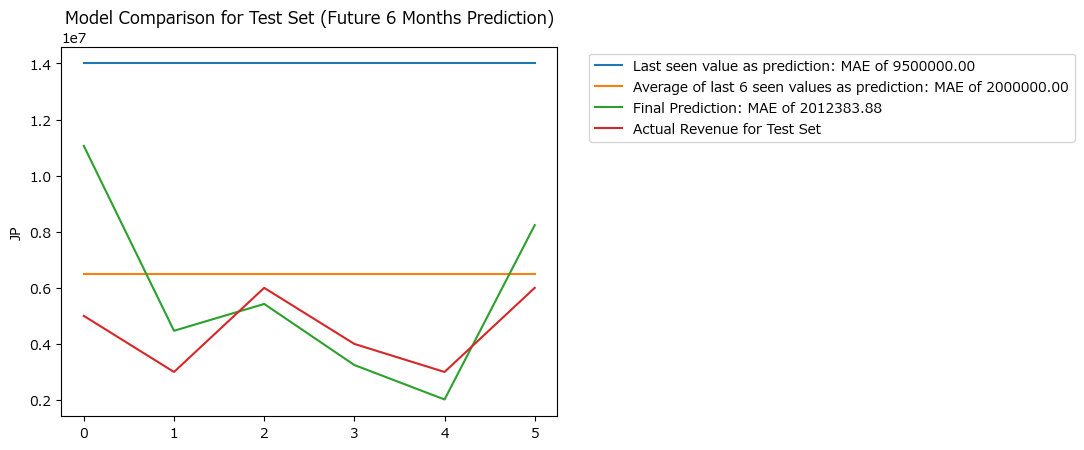

In [60]:
last_training_revenue = y_train.iloc[-1]
last_6_training_revenue_avg = y_train.iloc[-6:].mean()
naive_prediction = [last_training_revenue] * 6
not_so_naive_prediction = [last_6_training_revenue_avg] * 6

mae_naive = mean_absolute_error(y_test, naive_prediction)
mae_not_so_naive = mean_absolute_error(y_test, not_so_naive_prediction)
mae_final = mean_absolute_error(y_test, final_pred)

print(f'MAE (last seen value as prediction): {mae_naive}')
print(f'MAE (average of last 6 seen values as prediction): {mae_not_so_naive}')
print(f'MAE for Final Prediction: {mae_final}')

plt.tight_layout()

sns.lineplot(naive_prediction, label=f'Last seen value as prediction: MAE of {mae_naive:.2f}')
sns.lineplot(not_so_naive_prediction, label=f'Average of last 6 seen values as prediction: MAE of {mae_not_so_naive:.2f}')
sns.lineplot(final_pred, label=f'Final Prediction: MAE of {mae_final:.2f}')
sns.lineplot(y_test.reset_index(drop=True), label='Actual Revenue for Test Set')

plt.title('Model Comparison for Test Set (Future 6 Months Prediction)')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # Move legend outside
plt.show()

As seen, our model outperforms the naive model by over a factor of 4. This means that we immediately see a big reduction in the error! 

However, the MAE for the avg past 6 values are similar to our final model. As seen in the graph, that appears mainly to be caused by a big outlier for the first prediction. Let's have a look at the MAE without the exception:

MAE for Final Prediction (excluding 1st Month): 1202673.45


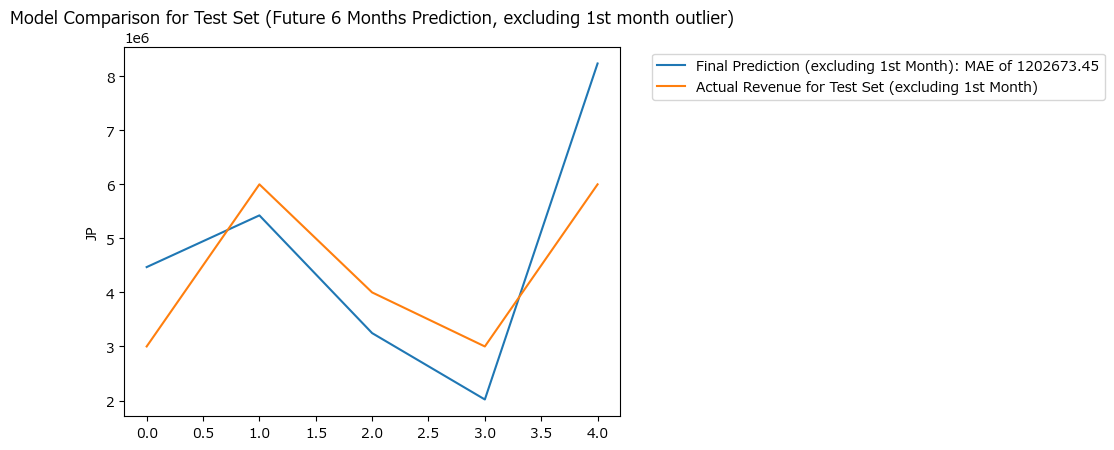

In [61]:
# remove the first month prediction and actual value as it is an outlier
final_pred_no_outlier = final_pred.copy()[1:]
y_test_no_outlier = y_test.iloc[1:]

mae_final = mean_absolute_error(y_test_no_outlier, final_pred_no_outlier)

print(f'MAE for Final Prediction (excluding 1st Month): {mae_final:.2f}')

plt.tight_layout()

sns.lineplot(final_pred_no_outlier, label=f'Final Prediction (excluding 1st Month): MAE of {mae_final:.2f}')
sns.lineplot(y_test_no_outlier.reset_index(drop=True), label='Actual Revenue for Test Set (excluding 1st Month)')

plt.title('Model Comparison for Test Set (Future 6 Months Prediction, excluding 1st month outlier)')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # Move legend outside
plt.show()

The MAE has dropped to just 1,200,000! This is a good result, considering the revenue has historically gone up to a maximum of 19 million (so that's about 6% of 19 million).

## Directional Accuracy

Apart from the MAE, we want to observe _trends_. To do so, we will use a simple tool: directionaly accuracy. Often, stakeholders are interested whether profits will go up or down (as a measure of the well-being of a game). Therefore, we will simply calculate how much of the time the predicted change in direction is the same as the actual change in direction.

For example, if month 1 actually sees 10 million dollars in revenue, and month 2 actually sees 7 million dollars in revenue, the direction is down. So if our model predicts 8 million dollars, it is still less that 10 million dollars (and hence the direction is also down). 

Based on the graph above, we have correctly predicted 6 out of 6 changes in direction! (see how the red line moves up and down in tandem with the green line) Therefore, our model provides further insights to how revenue will change that the 6 month average solution cannot provide.

# Model Limitations

There are some (inherent) limitations in the model as described below:

## Accuracy of Data

Much of the data is scanned from fan sites and online posts, making collecting suitable data tedious and not super reliable. Furthermore, the fact that the data is scattered across multiple changing sites (instead of everything being available via a single API) makes it difficult to update automatically and probably requires some web scraping. Hence, I have not implemented a mechanism to automatically update these data points to the newest ones. 

If I had access to such data, it would likely make the model more accurate and easy to maintain. Collecting data is 90% of the battle.

## Granularity of Data

The revenue data I collected is on a per-month basis. However, banners run for typically a week or so, which is much shoter than a month. Having weekly revenue statistics would likely make the predictions more accurate. 

For example, in the first future month we predicted, a Fes Banner (recap: the rarest banner) ended right at the start of the month. Even if people don't spend much for the next 3 weeks, the fact that there are 3 Fes banners that month can lead to an overestimation for that specific month.

(This is exactly what we see: ~1.1 million predicted vs ~0.5 million actual for the first predicted month).

## Small Number of Data Points 

For our training set, we only have 39 months of data which is on the smaller side for capturing overall trends. Furthermore, creating rollng mean and standard deviation further reduces the test set size.

# Conclusion / Summary

* A hybrid model combining a spline model and XGB model was created to produce forecasts of future revenue for Blue Archive, for up to 6 months. 
* The spline model was degree 1 with 7 knots, while the XGB model consisted of 40 learners and 0.1 learning rate. The model outperformed the naive model, with a MAE of 1.2 million (excluding the outlier).
* Furthermore, the directional accuracy was excellent, predicting 6 out of 6 changes in direction of revenue.
* This model enables stakeholders to schedule events efficiently, budget and allocate resources, and test what-if scenarios.